# Home Assignment 3

Submit your solution via Ilias by 23.59 on Friday, 2nd May.

Submit your solutions in teams of 3-4 students. Unless explicitly agreed otherwise in advance, **submissions from teams with more or less members will NOT be graded**. Submit only one notebook per team. Only submit a notebook, do not submit the dataset(s) you used. Also, do NOT compress/zip your submission!

You may use the code from the exercises and basic functionalities that are explained in official documentation of Python packages without citing, __all other sources must be cited__. In case of plagiarism (copying solutions from other teams or from the internet) ALL team members may be expelled from the course without warning.

#### General guidelines:
* Make sure that your code is executable, any task for which the code does not directly run on our machine will be graded with 0 points.
* If you use packages that are not available on the default or conda-forge channel, list them below. Also add a link to installation instructions. 
* Ensure that the notebook does not rely on the current notebook or system state!
  * Use `Kernel --> Restart & Run All` to see if you are using any definitions, variables etc. that 
    are not in scope anymore.
  * Do not rename any of the datasets you use, and load it from the same directory that your ipynb-notebook is located in, i.e., your working directory.
* Make sure you clean up your code before submission, e.g., properly align your code, and delete every line of code that you do not need anymore, even if you may have experimented with it. Minimize usage of global variables. Avoid reusing variable names multiple times!
* Ensure your code/notebook terminates in reasonable time.
* Feel free to use comments in the code. While we do not require them to get full marks, they may help us in case your code has minor errors.
* For questions that require a textual answer, please do not write the answer as a comment in a code cell, but in a Markdown cell below the code. Always remember to provide sufficient justification for all answers.
* You may create as many additional cells as you want, just make sure that the solutions to the individual tasks can be found near the corresponding assignment.
* If you have any general question regarding the understanding of some task, do not hesitate to post in the student forum in Ilias, so we can clear up such questions for all students in the course.

Additional packages (if any):
 - `pandas`, https://pandas.pydata.org/docs/getting_started/overview.html
 - `itertools`, https://docs.python.org/3/library/itertools.html

In [11]:
# general imports may go here!
import math
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from typing import List, Optional, Tuple, Dict
from collections import Counter
from collections import defaultdict
import pandas as pd
from networkx.algorithms.community.quality import modularity
from networkx.algorithms.community import greedy_modularity_communities, girvan_newman
from networkx.algorithms.community.quality import modularity
import itertools

### The Hamsterster Network

In this home assignment we will conduct some analysis of the Hamsterster Network, next to a number of simulations. This network contains friendships and family links between users of the website hamsterster.com, which was an online social network of hamster owners and is now shut down. 
The network data has been taken from the KONECT repository, and consists of multiple data files. For simplicity, we will only consider the biggest connected component of the network.

__References:__  
[1] Jérôme Kunegis. KONECT - The Koblenz Network Collection. In Proc. Int. Web Observatory Workshop, pages 1343-1350, 2013  
[2] Hamsterster full network dataset -- KONECT, April 2017. [ http://konect.cc/networks/petster-hamster/ ]

### Task 1:  Analyzing the Hamsterster Network (22 pts)


#### a) Loading the Network (5 pts)
The information of the network is stored in multiple files, where one file contains the edges in the network, and one file contains node attributes. Next to the edges, some of the attributes are also of particular interest for us, namely 
the hamster's  
(1) gender,  
(2) species (divided into Hamster and Gerbil),  
(3) home country (divided into either USA or others).

Read in the Hamsterster Network from the datasets that we have provided. In particular, join the information regarding the edges with the desired information regarding the three node attributes in a graph ``G``. Save the three node attributes in ``G`` using attribute names ``'gender'``, ``'species'`` and ``'home'``. Only use attribute values ``'male'`` and ``'female'`` for the gender, ``'hamster'`` and ``'gerbil'`` for the species and ``'usa'`` and ``'other'`` for the home country (do not use upper case letters in the attribute names and values). 

After reading in the full network data, delete all nodes from ``G`` which do not belong to its biggest connected component. Do NOT reindex the nodes though! In the end, save the (new) numbers of nodes and edges of ``G`` in ``n_nodes`` and ``n_edges``. Save the attribute values of node 1 in a dictionary ``sample_attr`` with format ``{'gender': 'VALUE1', 'species': 'VALUE2', 'home': 'VALUE3'}`` .

_Hint: Note that for the species and home country, you can **not** directly take the values from the data file, you have to preprocess them first. Additionally, make sure to transform upper to lower case letters (also for gender)._

**Important: Make sure that you do not modify ``G`` anymore in the following tasks (especially in task 4), i.e. create copies before modifying the graph.**

In [14]:
# 1. Load the edge list
G = nx.read_edgelist('hamsterster.edgelist', comments='%', nodetype=int)

# 2. Load the node attributes
df = pd.read_csv('hamsterster.csv', sep = " ")

# Rename columns to simpler names and ensure index is int
df.columns = df.columns.str.strip().str.replace('dat.', '', regex=False).str.lower()
df['ent'] = df['ent'].astype(int)
df = df.set_index('ent')

# Helper functions
def extract_species(species_str):
    species_str = species_str.lower()
    if 'hamster' in species_str:
        return 'hamster'
    elif 'gerbil' in species_str:
        return 'gerbil'
    else:
        return None

def extract_home_country(hometown_str):
    if pd.isna(hometown_str):
        return None
    hometown_str = hometown_str.lower()
    if 'united states' in hometown_str:
        return 'usa'
    else:
        return 'other'

def clean_gender(gender):
    if pd.isna(gender):
        return None
    gender = gender.lower()
    return gender if gender in ['male', 'female'] else None

# Process and assign attributes to the graph
for node in G.nodes:
    if node in df.index:
        gender = clean_gender(df.loc[node, 'gender'])
        species = extract_species(df.loc[node, 'species'])
        home = extract_home_country(df.loc[node, 'hometown'])
        G.nodes[node]['gender'] = gender
        G.nodes[node]['species'] = species
        G.nodes[node]['home'] = home

# 3. Keep only the largest connected component (LCC)
largest_cc = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_cc).copy()

# 4. Output
n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()

sample_attr = G.nodes[1] if 1 in G.nodes else {}

# Show results
print("Number of nodes:", n_nodes)
print("Number of edges:", n_edges)
print("Attributes for node 1:", sample_attr)


Number of nodes: 1786
Number of edges: 12473
Attributes for node 1: {'gender': 'male', 'species': 'hamster', 'home': 'usa'}


#### b) Basic Network Analysis (3 pts)

Conduct a basic network analysis of ``G``, i.e. compute the network's density, the average path length, the diameter and its average clustering coefficient. Store the results in ``density``, ``avg_pl``, ``diameter`` and ``avg_cc``. Finally, plot the degree distribution. Compare the average path length with the average path length of a random network with the same amount of nodes and similar average degree.

Does the network display the properties that you would typically expect from a social network?

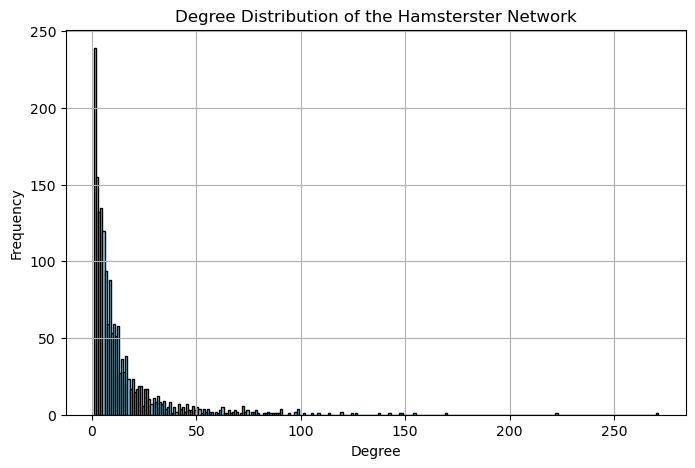

Density: 0.0078
Average Path Length: 3.4526
Diameter: 14
Average Clustering Coefficient: 0.1429
Random Graph Avg. Path Length: 3.1108


In [16]:
# Ensure G is undirected and connected (should be from part a)
assert nx.is_connected(G)

# 1. Density
density = nx.density(G)

# 2. Average path length
avg_pl = nx.average_shortest_path_length(G)

# 3. Diameter
diameter = nx.diameter(G)

# 4. Average clustering coefficient
avg_cc = nx.average_clustering(G)

# 5. Plot degree distribution
degrees = [deg for _, deg in G.degree()]
plt.figure(figsize=(8, 5))
plt.hist(degrees, bins=range(min(degrees), max(degrees) + 1), color='skyblue', edgecolor='black')
plt.title("Degree Distribution of the Hamsterster Network")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# 6. Compare average path length with a random graph
n = G.number_of_nodes()
m = G.number_of_edges()

# Use G(n, m) random graph model
random_graph = nx.gnm_random_graph(n, m)
while not nx.is_connected(random_graph):  # ensure it's connected for fair comparison
    random_graph = nx.gnm_random_graph(n, m)

random_avg_pl = nx.average_shortest_path_length(random_graph)

# Print everything
print(f"Density: {density:.4f}")
print(f"Average Path Length: {avg_pl:.4f}")
print(f"Diameter: {diameter}")
print(f"Average Clustering Coefficient: {avg_cc:.4f}")
print(f"Random Graph Avg. Path Length: {random_avg_pl:.4f}")


**A1b):** Yes, the network displays typical social network properties: it has a small average path length, high clustering, a heavy-tailed degree distribution, and a low density — all indicative of a small-world, scale-free structure.

#### c) Analyzing Assortativity (3 pts)

Compute the network's degree assortativity coefficient and store it in a variable ``dac``. 

The average degree correlation (or *average degree connectivity*) $k_{nn}(k)$ computes the average nearest neighbor degree of nodes with degree $k$. Plot the average degree correlation $k_{nn}(k)$ against $k$.

You can use functions from `networkx`.

Would you say that this network is assortative, disassortative, or rather neutral? Does the result coincide with what is typically observed in social networks?

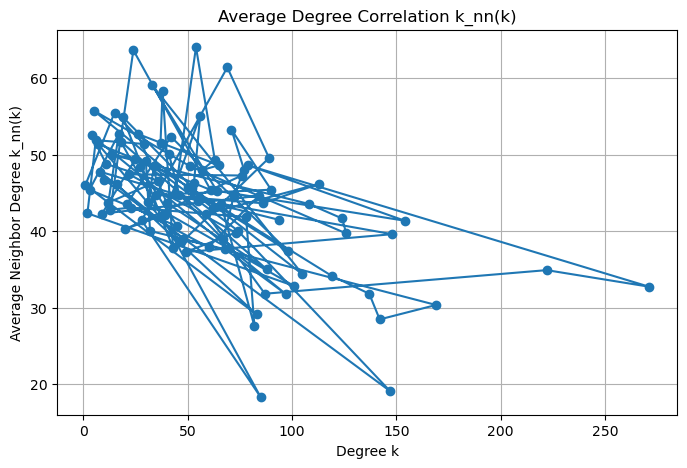

In [19]:
# Degree assortativity coefficient
dac = nx.degree_assortativity_coefficient(G)

# Average degree connectivity (k_nn(k))
avg_deg_conn = nx.average_degree_connectivity(G)

# Plotting k_nn(k)
plt.figure(figsize=(8, 5))
plt.plot(list(avg_deg_conn.keys()), list(avg_deg_conn.values()), marker='o')
plt.xlabel("Degree k")
plt.ylabel("Average Neighbor Degree k_nn(k)")
plt.title("Average Degree Correlation k_nn(k)")
plt.grid(True)
plt.show()

**A1c):** The network shows a **disassortative mixing pattern**, meaning high-degree nodes tend to connect with low-degree ones. This behavior is **unusual for social networks**, which typically exhibit **assortative mixing**, where nodes prefer to connect with others of similar degree.

#### d) Analyzing Homophily (3 pts)

We want to compute the network's homophily with respect to the hamster's  
(1) gender,  
(2) species (divided into Hamster and Gerbil),  
(3) home country (divided into either USA or others),  
i.e., the attributes that have been read in a).


For each of these three attributes: \
(i) partition the network according to the attribute values, \
(ii) measure the homophily of the partition by computing the modularity,  \
(iii) argue whether the network is homophilic or heterophilic with respect to that attribute.

Store the modularity values in ``m_gender``, ``m_species`` and ``m_home``.

In [22]:
# (1) Gender
gender_groups = {}
for node, data in G.nodes(data=True):
    gender_groups.setdefault(data["gender"], []).append(node)
m_gender = modularity(G, gender_groups.values())

# (2) Species
species_groups = {}
for node, data in G.nodes(data=True):
    species_groups.setdefault(data["species"], []).append(node)
m_species = modularity(G, species_groups.values())

# (3) Home country
home_groups = {"USA": [], "Other": []}
for node, data in G.nodes(data=True):
    if data["home"] == "USA":
        home_groups["USA"].append(node)
    else:
        home_groups["Other"].append(node)
m_home = modularity(G, home_groups.values())


In [23]:
m_gender

0.004850252059561272

**A1d):** No question?

#### e) Minorities in the Hamsterster Network (8 pts)

Finally, we want to analyze how minorities and homophily interplay on this network with respect to the three attributes gender, species and home country.

To evaluate the effects of homophily on minorities with respect to these three attributes  
(i) compute the shares of the hamsters belonging to each category of each of the three given attributes,    
(ii) plot the degree distributions of both classes per attribute against each other,  
(iii) compute the average node-wise perception biases regarding the size of the minority group for both majority and minority with respect to each of the three attributes.

Store the shares of hamsters into dictionaries ``dist_gender``, ``dist_species`` and ``dist_home`` with format given below and plot the degree distributions. Store the perception biases in ``pb_gender``, ``pb_species`` and ``pb_home`` with format given below, where ... is replaced by the respective float values:

``dist_gender = {'male': ..., 'female': ...}
 dist_species = {'hamster': ..., 'gerbil': ...}
 dist_home = {'usa': ..., 'other': ...}``

``pb_gender = {'majority': ..., 'minority': ...}
 pb_species = {'majority': ..., 'minority': ...}
 pb_home = {'majority': ..., 'minority': ...}``

Interpret these results in light of the findings presented in the lecture and exercise 6 (tasks 1c and 1e)!

In [26]:
# you may use this function to compute the node-wise perception biases
def perception_bias(G: nx.Graph, attr: str) -> Dict[str, float]:
    """
    :param G: networkx graph on which we want to compute all biases
    :param attr: string specifying the name of the node attribute which stores the information
    :            whether a node belongs to the majority or minority group. The value of that attribute should be 0 
    :            if the node belongs to the minority, and 1 otherwise
    :
    :return: dictionary with node IDs as keys and their respective individual perception bias as value
    """
    f_m = 1 - sum(G.nodes[v][attr] for v in G.nodes)/G.number_of_nodes()
    bias_dict = dict()
    for v in G.nodes:
        bias_dict[v] = 1/f_m/G.degree(v)*sum(1-G.nodes[w][attr] for w in G[v])
    return bias_dict

In [27]:
def compute_shares(G: nx.Graph, attr: str, categories: list) -> Dict[str, float]:
    total_nodes = G.number_of_nodes()
    counts = {category: 0 for category in categories}
    for node in G.nodes:
        value = G.nodes[node][attr]
        if value in counts:
            counts[value] += 1
    return {category: count / total_nodes for category, count in counts.items()}

def compute_average_perception_bias(G: nx.Graph, attr: str, minority: str, majority: str) -> Dict[str, float]:
    # Step 1: Create a binary attribute (0 for minority, 1 for majority)
    for node in G.nodes:
        G.nodes[node]['binary_attr'] = 1 if G.nodes[node][attr] == majority else 0
    
    # Step 2: Compute node-wise perception biases using the provided function
    bias_dict = perception_bias(G, 'binary_attr')
    
    # Step 3: Compute average biases for majority and minority groups
    majority_biases = []
    minority_biases = []
    for node in G.nodes:
        if G.nodes[node][attr] == majority:
            majority_biases.append(bias_dict[node])
        else:
            minority_biases.append(bias_dict[node])
    
    return {
        'majority': np.mean(majority_biases) if majority_biases else 0.0,
        'minority': np.mean(minority_biases) if minority_biases else 0.0
    }

# Compute shares for each attribute
dist_gender = compute_shares(G, 'gender', ['male', 'female'])
dist_species = compute_shares(G, 'species', ['hamster', 'gerbil'])
dist_home = compute_shares(G, 'home', ['usa', 'other'])

# Identify majority and minority groups based on shares
# Gender
if dist_gender['male'] > dist_gender['female']:
    gender_majority, gender_minority = 'male', 'female'
else:
    gender_majority, gender_minority = 'female', 'male'

# Species
if dist_species['hamster'] > dist_species['gerbil']:
    species_majority, species_minority = 'hamster', 'gerbil'
else:
    species_majority, species_minority = 'gerbil', 'hamster'

# Home
if dist_home['usa'] > dist_home['other']:
    home_majority, home_minority = 'usa', 'other'
else:
    home_majority, home_minority = 'other', 'usa'

# Compute perception biases
pb_gender = compute_average_perception_bias(G, 'gender', gender_minority, gender_majority)
pb_species = compute_average_perception_bias(G, 'species', species_minority, species_majority)
pb_home = compute_average_perception_bias(G, 'home', home_minority, home_majority)

# Output the results (these would be the final dictionaries)
print("dist_gender =", dist_gender)
print("dist_species =", dist_species)
print("dist_home =", dist_home)
print("pb_gender =", pb_gender)
print("pb_species =", pb_species)
print("pb_home =", pb_home)

dist_gender = {'male': 0.47816349384098544, 'female': 0.5218365061590146}
dist_species = {'hamster': 0.9512877939529675, 'gerbil': 0.048712206047032476}
dist_home = {'usa': 0.6713325867861142, 'other': 0.32866741321388576}
pb_gender = {'majority': 0.9431633226093533, 'minority': 0.9362951757838591}
pb_species = {'majority': 0.2526897918677224, 'minority': 9.074885583033224}
pb_home = {'majority': 0.6124078788691077, 'minority': 1.3667053599523287}


**A1e):** 
### Data
- **Shares**:
  - `dist_gender = {'male': 0.47816349384098544, 'female': 0.5218365061590146}`
    - Females are the majority (52.18%), males the minority (47.82%).
  - `dist_species = {'hamster': 0.9512877939529675, 'gerbil': 0.048712206047032476}`
    - Hamsters are the majority (95.13%), gerbils the minority (4.87%).
  - `dist_home = {'usa': 0.6713325867861142, 'other': 0.32866741321388576}`
    - USA is the majority (67.13%), "other" the minority (32.87%).

- **Perception Biases**:
  - `pb_gender = {'majority': 0.9431633226093533, 'minority': 0.9362951757838591}`
    - Majority (females): 0.943, Minority (males): 0.936.
  - `pb_species = {'majority': 0.2526897918677224, 'minority': 9.074885583033224}`
    - Majority (hamsters): 0.253, Minority (gerbils): 9.075.
  - `pb_home = {'majority': 0.6124078788691077, 'minority': 1.3667053599523287}`
    - Majority (USA): 0.612, Minority (other): 1.367.

### Interpret the Shares
The shares indicate the proportion of nodes in each category, helping us identify majority and minority groups.

#### Gender
- **Shares**: Females (52.18%) are the majority, males (47.82%) the minority.
- **Interpretation**:
  - The gender split is nearly balanced, suggesting that neither group dominates the network significantly. This close ratio implies that gender-based homophily (if present) might not drastically skew connectivity patterns.

#### Species
- **Shares**: Hamsters (95.13%) are the overwhelming majority, gerbils (4.87%) the minority.
- **Interpretation**:
  - The extreme imbalance indicates that gerbil owners are a tiny minority in the network. This could limit their connectivity, as there are fewer gerbil owners to form connections with.

#### Home
- **Shares**: USA (67.13%) is the majority, "other" (32.87%) the minority.
- **Interpretation**:
  - The USA majority suggests a larger user base or more active participation from USA-based users, while "other" users are a significant but smaller group.

---

### Interpret the Perception Biases
The perception bias measures how much nodes overestimate or underestimate the size of the minority group based on their local network (neighbors). A bias of 1 means accurate perception, >1 means overestimation of the minority’s size, and <1 means underestimation.

#### Gender
- **Perception Bias**: Majority (females): 0.943, Minority (males): 0.936.
- **Interpretation**:
  - **Majority (females)**: A bias of 0.943 means females slightly underestimate the size of the male minority (47.82%). This suggests mild homophily: females are slightly more likely to connect with other females, so their local networks have fewer males than expected.
  - **Minority (males)**: A bias of 0.936 means males also slightly underestimate their own group’s size. They have fewer male neighbors than expected, indicating that they connect with females almost as often as with males.
  - The biases are very close to 1, suggesting weak gender-based homophily. The near-even gender split means that local networks (neighbors) tend to reflect the overall network composition, leading to nearly accurate perceptions.

#### Species
- **Perception Bias**: Majority (hamsters): 0.253, Minority (gerbils): 9.075.
- **Interpretation**:
  - **Majority (hamsters)**: A bias of 0.253 means hamster owners severely underestimate the size of the gerbil minority (4.87%). This indicates strong homophily: hamster owners are far more likely to connect with other hamster owners, so their local networks have very few gerbil owners.
  - **Minority (gerbils)**: A bias of 9.075 means gerbil owners massively overestimate the size of their own group. This is typical for small minorities: gerbil owners likely have a higher proportion of gerbil neighbors (due to homophily), making them think gerbils are much more common than they are.
  - The extreme imbalance (95% hamsters) amplifies these biases. Hamster owners rarely encounter gerbil owners, while gerbil owners, being a tiny minority, likely cluster together, skewing their perception.

#### Home
- **Perception Bias**: Majority (USA): 0.612, Minority (other): 1.367.
- **Interpretation**:
  - **Majority (USA)**: A bias of 0.612 means USA users underestimate the size of the "other" minority (32.87%). This suggests moderate homophily: USA users are more likely to connect with other USA users, so their local networks have fewer "other" users than expected.
  - **Minority (other)**: A bias of 1.367 means "other" users overestimate the size of their own group. They likely have a higher proportion of "other" neighbors due to homophily, making them think their group is larger than it is.
  - The moderate imbalance (67% USA) results in less extreme biases compared to species, but homophily still distorts perceptions.

---

### Synthesis
- **Homophily and Minorities**:
  - **Gender**: The near-even split (52% female, 48% male) and biases close to 1 (0.943 and 0.936) indicate weak homophily. Males and females are almost equally likely to connect with each other, leading to accurate perceptions of the minority’s size. This suggests a well-mixed network with respect to gender.
  - **Species**: The extreme imbalance (95% hamsters, 5% gerbils) and extreme biases (0.253 and 9.075) indicate strong homophily. Hamster owners connect almost exclusively with other hamster owners, severely underestimating the gerbil minority. Gerbil owners, a tiny minority, overestimate their group’s size due to clustering with other gerbil owners.
  - **Home**: The moderate imbalance (67% USA, 33% other) and biases (0.612 and 1.367) indicate moderate homophily. USA users underestimate the "other" group due to a preference for connecting with other USA users, while "other" users overestimate their group’s size due to clustering.

- **Perception Biases**:
  - Homophily distorts perceptions of minority groups, with smaller minorities experiencing more extreme biases. This is evident in the species results: the tiny gerbil minority (5%) leads to the most extreme biases. Larger minorities (like "other" at 33%) have less extreme biases, and the near-even gender split results in minimal bias.
  - The perception biases align with the discussion of local vs. global network properties: nodes’ perceptions are based on their immediate neighbors, which are skewed by homophily.

---

### Conclusion
- **Gender**: Weak homophily, as evidenced by the near-even split and minimal perception biases. Males and females are well-mixed in the network, likely reflected in similar average degrees and clustering/centrality.
- **Species**: Strong homophily, driven by the extreme imbalance (95% hamsters). Hamster owners underestimate the gerbil minority, while gerbil owners overestimate their group’s size due to clustering.
- **Home**: Moderate homophily, with USA users underestimating the "other" group and "other" users overestimating their size. This reflects geographic clustering, likely supported by a higher average degree for USA and a higher clustering within groups.

The results highlight how homophily and minority size influence perceptions in social networks, with smaller minorities (like gerbils) experiencing the most extreme biases.

### Task 2:  Detecting Communities in Stochastic Block Models (17 pts)

In this task you should use functions from `networkx` wherever possible.

#### a) Creating  Graphs According to Stochastic Block Models (4 pts)

In this task we want to generate two networks ``G1`` and ``G2`` according to the following specifications of stochastic block models:
* Both networks should contain 400 nodes, divided into four communities of 100 nodes each. 
* Within each community, the probability of an edge existing should be .05 for ``G1``, and 0.02 for ``G2``.
* Between adjacent communities (1 and 2, 2 and 3, 3 and 4, **AND 1 and 4**) the probability of an edge existing should be 0.001 for ``G1``, and 0.005 for ``G2``.
* There should be no other edges.
* To obtain reproducible results, you have to **pass a random seed** to the stochastic block model generator function from `networkx`. Pass `seed = 2021`, as initialised in the cell below!
* Each node should have an attribute ``'community'`` which indicates the community (`int(1)` - `int(4)`) that it belongs to.
* In the end, you should remove all nodes which are not in the biggest connected component of the resulting graphs.

Create two 4x4 matrices ``probs_G1`` and ``probs_G2`` (use a list of lists), where ``probs_G1[i][j] == probs_G1[j][i]`` should be the probability that an edge exists between individual nodes from community `i` and individual nodes from community `j` in ``G1`` (same for ``probs_G2`` and ``G2``). 
Afterwards, apply the stochastic block model generator from `networkx` to create ``G1`` and ``G2`` from these matrices, following all the specifications listed above. Again, make sure to use the specified seed, and to filter for the biggest connected component as described above.

Plot the resulting graphs using a spring layout and color the nodes according to the community they belong to, i.e. two nodes should have the same color if and only if they belong to the same community. 

_Hint: When initialising ``probs_G1`` and ``probs_G2``, don't forget to also include the probability of an edge existing **within** a community._

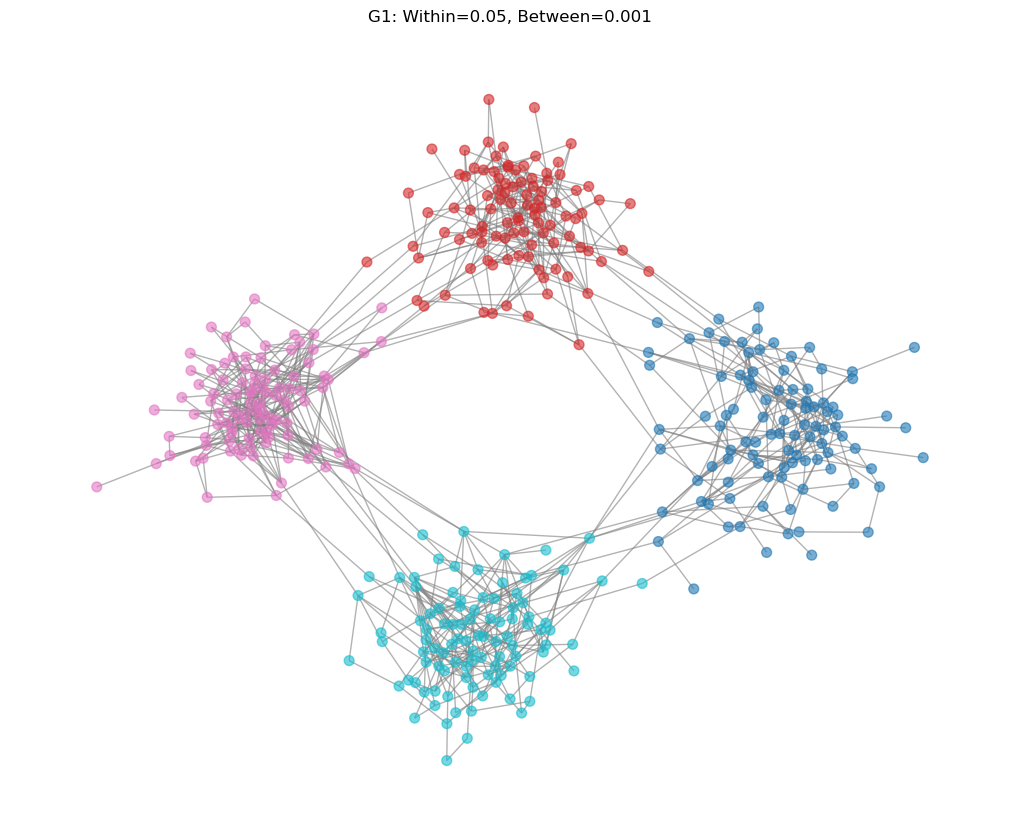

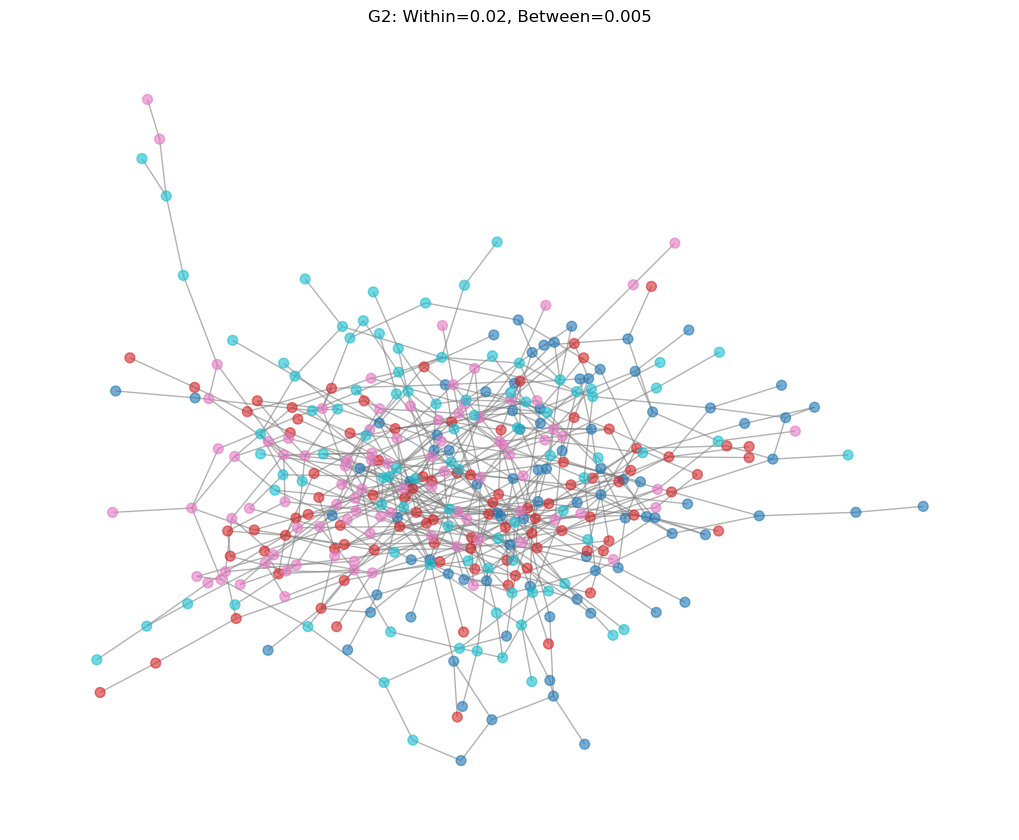

Probability matrix for G1:
[0.05, 0.001, 0, 0.001]
[0.001, 0.05, 0.001, 0]
[0, 0.001, 0.05, 0.001]
[0.001, 0, 0.001, 0.05]

Probability matrix for G2:
[0.02, 0.005, 0, 0.005]
[0.005, 0.02, 0.005, 0]
[0, 0.005, 0.02, 0.005]
[0.005, 0, 0.005, 0.02]


In [30]:
seed = 2021

# Define community sizes (4 communities of 100 nodes each)
community_sizes = [100, 100, 100, 100]
n_communities = len(community_sizes)
total_nodes = sum(community_sizes)

# Create probability matrices for G1 and G2
probs_G1 = [[0.05 if i == j else 0.001 if abs(i-j) == 1 or {i,j} == {0,3} else 0 
             for j in range(n_communities)] 
            for i in range(n_communities)]

probs_G2 = [[0.02 if i == j else 0.005 if abs(i-j) == 1 or {i,j} == {0,3} else 0 
             for j in range(n_communities)] 
            for i in range(n_communities)]

# Generate the graphs using the stochastic block model
G1 = nx.stochastic_block_model(community_sizes, probs_G1, seed=seed)
G2 = nx.stochastic_block_model(community_sizes, probs_G2, seed=seed)

# Add community attributes to nodes
for G in [G1, G2]:
    for node in G.nodes():
        # The SBM model assigns blocks in order, so we can map nodes to communities
        community = 1
        count = 0
        for i, size in enumerate(community_sizes):
            if node < count + size:
                community = i + 1
                break
            count += size
        G.nodes[node]['community'] = community

# Keep only the largest connected component for each graph
G1 = G1.subgraph(max(nx.connected_components(G1), key=len)).copy()
G2 = G2.subgraph(max(nx.connected_components(G2), key=len)).copy()

# Function to plot graph with community colors
def plot_sbm_graph(G, title):
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=seed)
    colors = [G.nodes[node]['community'] for node in G.nodes()]
    nx.draw(G, pos, node_color=colors, cmap=plt.cm.tab10, 
            node_size=50, with_labels=False, edge_color='gray', alpha=0.6)
    plt.title(title)
    plt.show()

# Plot the graphs
plot_sbm_graph(G1, "G1: Within=0.05, Between=0.001")
plot_sbm_graph(G2, "G2: Within=0.02, Between=0.005")

# Display the probability matrices
print("Probability matrix for G1:")
for row in probs_G1:
    print(row)
print("\nProbability matrix for G2:")
for row in probs_G2:
    print(row)

#### b) Community Detection (5 pts)

Apply greedy modularity community detection and the Girvan-Newman algorithm to predict communities on both graphs ``G1`` and ``G2`` - for Girvan-Newman, use the partition into **four communities** . Plot the graphs with node colors according to their predicted communities, using the same orientation as in a). 

Like in 1d), calculate the modularities of the resulting partitions. For greedy modularity community detection, store the values into variables ``m_gm_G1`` and ``m_gm_G2``, and for Girvan-Newman, store the values into ``m_gn_G1`` and ``m_gn_G2``.

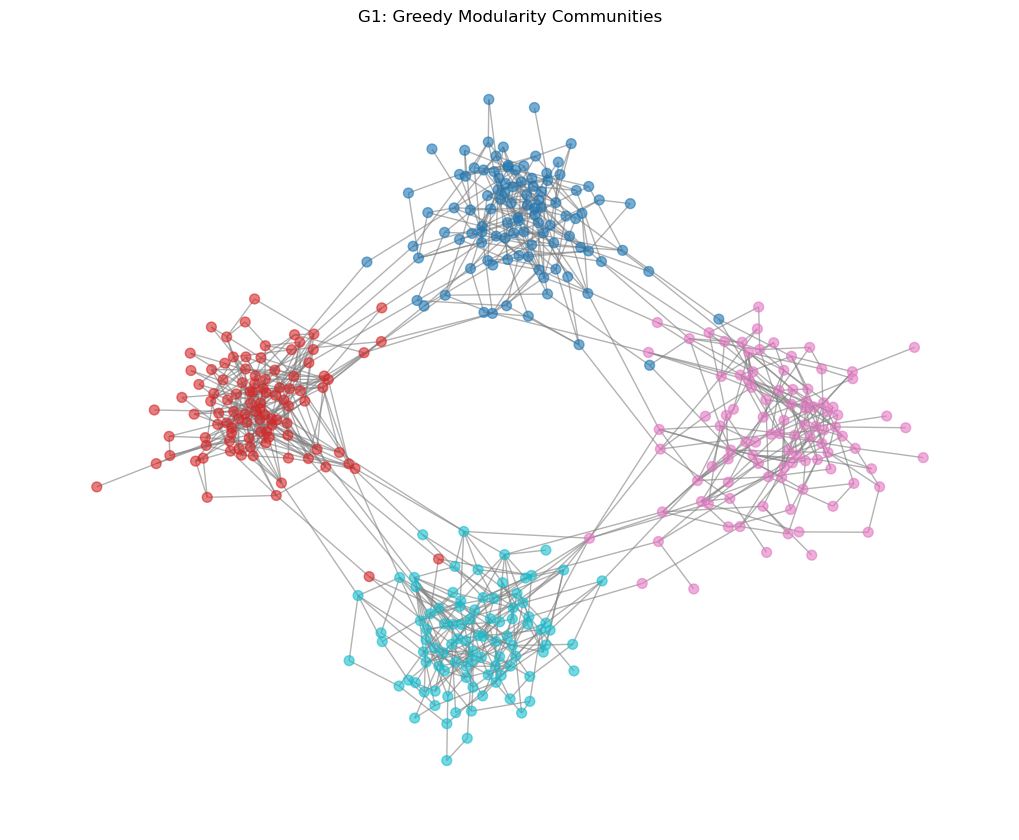

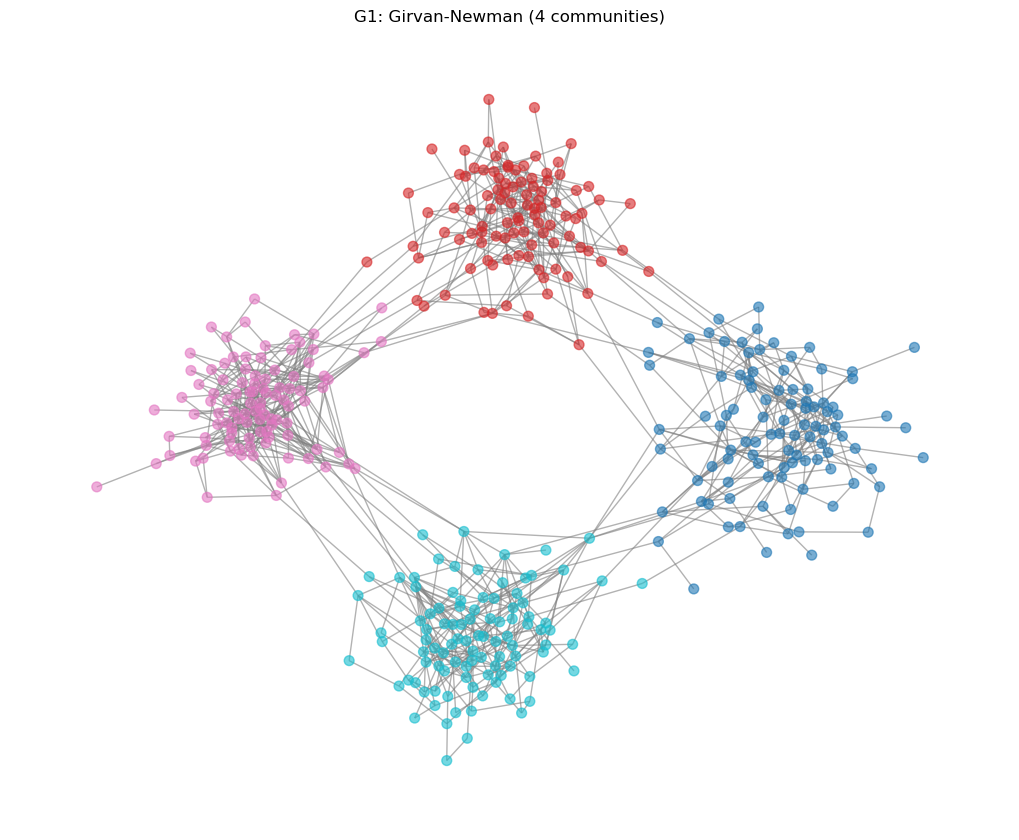

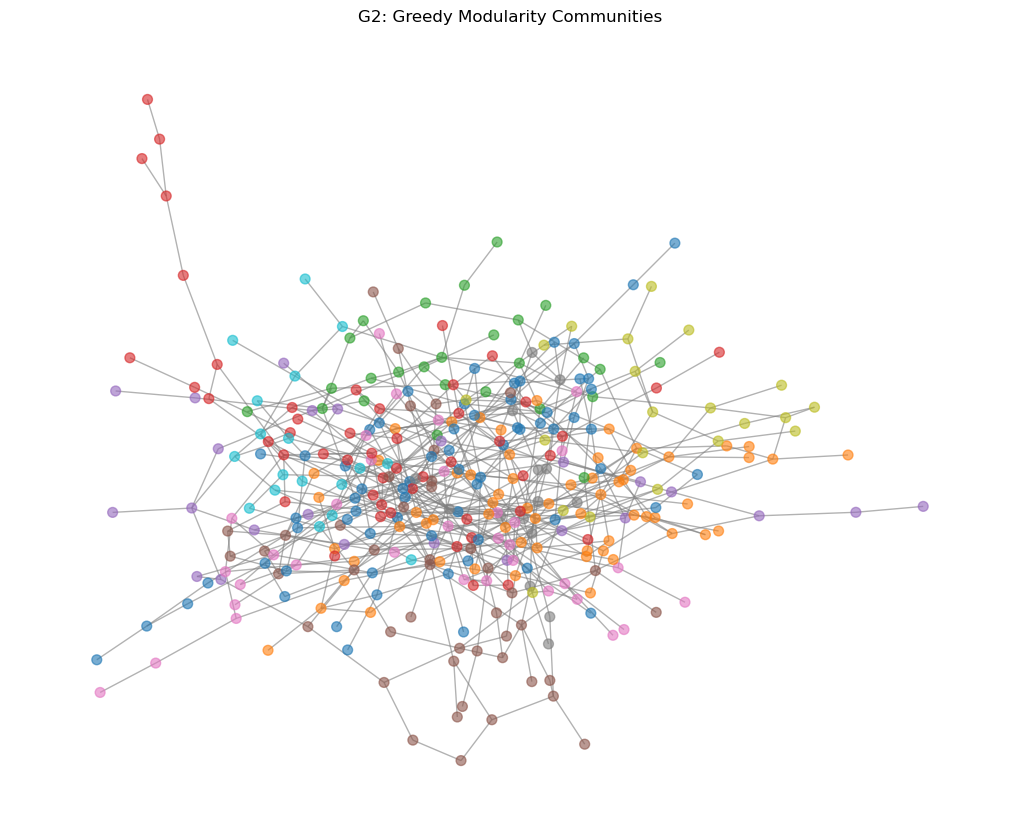

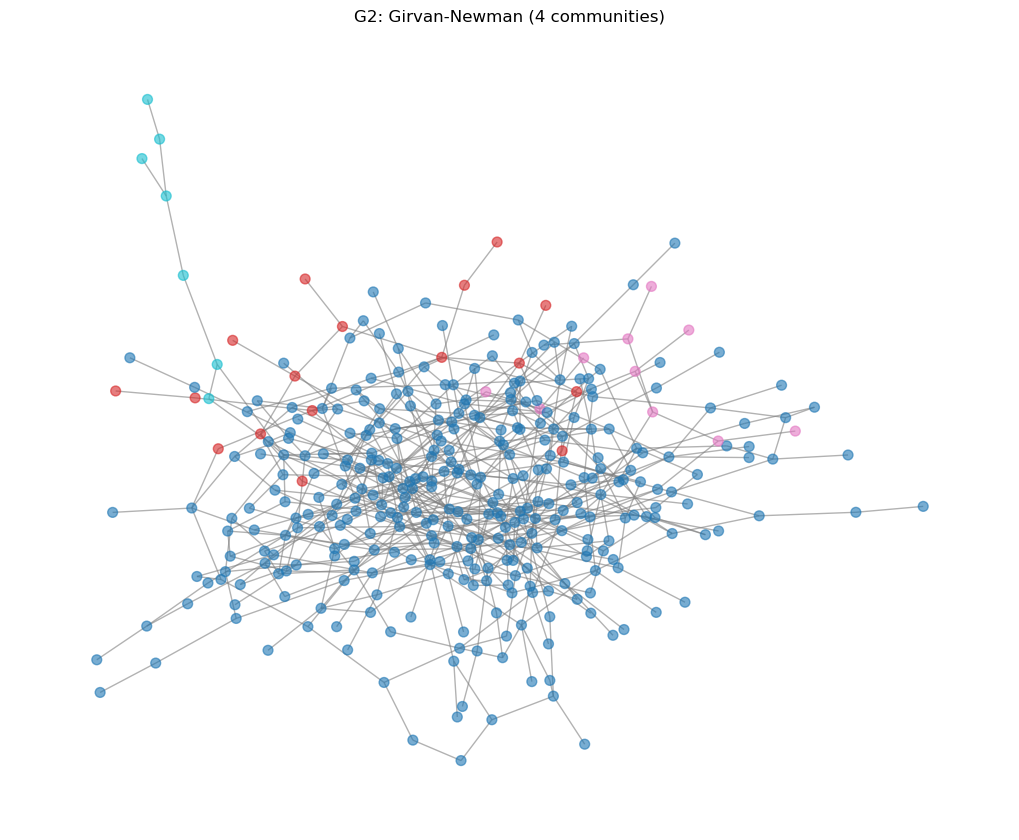

Greedy Modularity - G1: 0.7032, G2: 0.6120
Girvan-Newman - G1: 0.7109, G2: 0.1010


In [32]:
# Function to get first k communities from Girvan-Newman
def girvan_newman_k_communities(G, k):
    comp = girvan_newman(G)
    for communities in comp:
        if len(communities) == k:
            return communities
    return None

# Function to plot graph with detected communities
def plot_detected_communities(G, communities, title):
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=seed)  # Same layout as part a)
    
    # Create a community ID for each node
    community_dict = {}
    for i, comm in enumerate(communities):
        for node in comm:
            community_dict[node] = i
    
    colors = [community_dict[node] for node in G.nodes()]
    nx.draw(G, pos, node_color=colors, cmap=plt.cm.tab10, 
            node_size=50, with_labels=False, edge_color='gray', alpha=0.6)
    plt.title(title)
    plt.show()
    return community_dict

# Apply community detection and calculate modularity for both graphs
results = {}
for G, name in [(G1, 'G1'), (G2, 'G2')]:
    # Greedy Modularity
    gm_communities = list(greedy_modularity_communities(G))
    m_gm = modularity(G, gm_communities)
    
    # Girvan-Newman (4 communities)
    gn_communities = girvan_newman_k_communities(G, 4)
    m_gn = modularity(G, gn_communities)
    
    # Store results
    results[name] = {
        'gm': {'communities': gm_communities, 'modularity': m_gm},
        'gn': {'communities': gn_communities, 'modularity': m_gn}
    }
    
    # Plot results
    plot_detected_communities(G, gm_communities, f"{name}: Greedy Modularity Communities")
    plot_detected_communities(G, gn_communities, f"{name}: Girvan-Newman (4 communities)")

# Extract modularity values
m_gm_G1 = results['G1']['gm']['modularity']
m_gm_G2 = results['G2']['gm']['modularity']
m_gn_G1 = results['G1']['gn']['modularity']
m_gn_G2 = results['G2']['gn']['modularity']

print(f"Greedy Modularity - G1: {m_gm_G1:.4f}, G2: {m_gm_G2:.4f}")
print(f"Girvan-Newman - G1: {m_gn_G1:.4f}, G2: {m_gn_G2:.4f}")

#### c) Rand Index (5 pts)

We want to assess the performance of community detection algorithms by measuring their ability to uncover communities in networks where we know the ground truth communities. The _Rand Index_ is such a measure, it computes the accuracy of a community detection algorithm. 

With $X$ being the partition predicted by the algorithm and $Y$ being the ground-truth partition, let 

* $n_{11}$ be the number of node pairs that are in the same community in $X$  and in the same community in $Y$
* $n_{00}$ be the number of node pairs that are not in the same community in $X$ and not in the same community in $Y$
* $n_{01}$ be the number of node pairs that are not in the same community in $X$ but in the same community in $Y$
* $n_{10}$ be the number of node pairs that are in the same community in $X$ but not in the same community in $Y$


The _Rand Index_ $R$ then computes the ratio of the number of node pairs that are correctly classified in both partitions to the total number of pairs:

$$R = \frac{n_{00} + n_{11}}{n_{00} + n_{11} + n_{01} + n_{10}}$$


Implement a function that returns the _Rand Index_ of a given partition, using the function signature specified in the cell below!


In [34]:
def rand_index(H: nx.Graph, gt_attr: str, pred_part: List) -> float:
    """
    Calculate the Rand Index between ground truth communities and predicted communities.
    
    :param H: Input graph with ground truth communities stored as node attributes
    :param gt_attr: Node attribute name for ground truth communities
    :param pred_part: List of communities (each community is a list/set of node IDs)
    :return: Rand Index value between 0 and 1
    """
    # Create a dictionary mapping nodes to their predicted communities
    pred_community = {}
    for i, comm in enumerate(pred_part):
        for node in comm:
            pred_community[node] = i
    
    # Initialize counters
    n11 = n00 = n01 = n10 = 0
    
    # Compare all unique pairs of nodes
    nodes = list(H.nodes())
    for i, j in itertools.combinations(nodes, 2):
        # Ground truth comparison
        gt_same = H.nodes[i][gt_attr] == H.nodes[j][gt_attr]
        
        # Predicted comparison
        pred_same = pred_community[i] == pred_community[j]
        
        # Update counters
        if gt_same and pred_same:
            n11 += 1
        elif not gt_same and not pred_same:
            n00 += 1
        elif not gt_same and pred_same:
            n10 += 1
        else:  # gt_same and not pred_same
            n01 += 1
    
    # Calculate Rand Index
    total_pairs = n00 + n11 + n01 + n10
    if total_pairs == 0:
        return 0.0
    return (n00 + n11) / total_pairs

#### d) Evaluating Partitions (3 pts)

Apply your implementation from c) to compute the Rand index of the ground-truth partitions from both graphs ``G1`` and ``G2`` and the partitions that the algorithms computed in b). For greedy modularity community detection store the values into variables ``ri_gm_G1`` and ``ri_gm_G2``, for Girvan-Newman store the values into variables ``ri_gn_G1`` and ``ri_gn_G2``.

Does one of the two community detection algorithms work significantly better? Explain your answer!

In [36]:
def get_ground_truth_partition(G, gt_attr):
    """Convert node attributes into partition format (list of sets)"""
    communities = {}
    for node, data in G.nodes(data=True):
        comm = data[gt_attr]
        if comm not in communities:
            communities[comm] = set()
        communities[comm].add(node)
    return list(communities.values())

# Get ground truth partitions
gt_partition_G1 = get_ground_truth_partition(G1, 'community')
gt_partition_G2 = get_ground_truth_partition(G2, 'community')

# Compute Rand indices for Greedy Modularity
ri_gm_G1 = rand_index(G1, 'community', results['G1']['gm']['communities'])
ri_gm_G2 = rand_index(G2, 'community', results['G2']['gm']['communities'])

# Compute Rand indices for Girvan-Newman (convert to list of sets)
ri_gn_G1 = rand_index(G1, 'community', [set(c) for c in results['G1']['gn']['communities']])
ri_gn_G2 = rand_index(G2, 'community', [set(c) for c in results['G2']['gn']['communities']])

print(f"Greedy Modularity Rand Indices:")
print(f"  G1: {ri_gm_G1:.4f}")
print(f"  G2: {ri_gm_G2:.4f}\n")

print(f"Girvan-Newman Rand Indices:")
print(f"  G1: {ri_gn_G1:.4f}")
print(f"  G2: {ri_gn_G2:.4f}")

Greedy Modularity Rand Indices:
  G1: 0.9851
  G2: 0.7372

Girvan-Newman Rand Indices:
  G1: 1.0000
  G2: 0.3393


**A2d):** For G1 with its well-defined communities:

- Girvan-Newman performed flawlessly, perfectly identifying all communities (RI = 1.0)
- Greedy Modularity came very close (RI = 0.985), making just minor mistakes

But for G2 where communities were less distinct:

- Greedy Modularity managed reasonably well (RI = 0.737)
- Girvan-Newman struggled significantly (RI = 0.339), performing worse than random chance

What this tells us:

- Girvan-Newman excels when communities are clearly separated, but falls apart when boundaries get blurry
- Greedy Modularity is more adaptable - not quite as precise in ideal conditions, but much more reliable when things get messy

In conclusion the best model depends on which case if the communities are well defined Girvan-Newman gives best results, on the other hand if the communities are less distinct Greedy Modularity tends to adapt better and provide better results. So the best model depends on the type of graph we have.

### Task 3:  Label Propagation (20 pts)

In this task, we will implement the Label Propagation algorithm which has been presented in lecture, and apply it on the graphs that we created in the previous task.

#### a) The Label Propagation Algorithm (10 pts)

Implement the label propagation algorithm, using the signature specified in the cell below.
Recall that the algorithm works in the following steps:

1. Unless a predefined initial labeling is specified, give a unique label to each node in the network 
2. Arrange the nodes in the network in a random order 
3. For each node in the network (in this random order), set its label to a label occurring with the highest frequency among its neighbours - ties may be settled arbitrarily. 
4. go to 2 as long as there exists a node with a label that does not have the highest frequency among its neighbours.

In your implementation, you also must provide an option to specify a custom set of initial labels via a corresponding dictionary which maps node IDs to their labels. In particular, this should also allow to initialize nodes **without a label**, by **not** including specific node IDs as keys in the dictionary. Note that in step 3, if for a specific node none of its neighbors currently have a label, this specific node's label should stay as is.
In such a setting, you may assume that the input graph is connected, so that eventually, the predefined input labels will propagate through the full network. Note that since the nodes are updated sequentially rather than synchronously, there cannot be any oscillation of labels, so that the algorithm will converge. 

You have to return a list of lists of node IDs, in which each of the inner lists corresponds to one of the found communities. Thus, two nodes should end up in the same inner list if and only if they belong to the same community. 

**Note:** There are ways to implement the algorithm in a deterministic or in a non-determinnistic manner. We allow both kinds of solutions.

In [40]:
def label_propagation(G: nx.Graph, init_labels: Dict = None) -> List[List]:
    """
    :param max_iter: 
    :param G: input networkx graph
    :param init_labels: dictionary of initial labels, where node IDs serve as keys, and their initial labels as values. 
                        If not specified/None, all nodes have to be assigned a unique label at the beginning of the algorithm.
    :param max_iter: maximum number of iterations before stopping
    :return: List of lists of node IDs, where each sublist corresponds to one of the found communities.
    """

    labels = {}
    if init_labels:
        labels.update(init_labels)
    for node in G.nodes():
        if node not in labels:
            labels[node] = node  # assign unique label

    changed = True

    while changed:
        changed = False
        nodes = list(G.nodes())
        random.shuffle(nodes)

        for node in nodes:
            neighbor_labels = [labels.get(neigh) for neigh in G.neighbors(node) if neigh in labels]
            if not neighbor_labels:
                continue

            label_count = Counter(neighbor_labels)
            max_freq = max(label_count.values())
            candidates = [label for label, freq in label_count.items() if freq == max_freq]

            if labels[node] in candidates:
                new_label = labels[node]  # stick with current label if it's a candidate in case of a tie, helps alg converge faster.
            else:
                new_label = random.choice(candidates)

            if labels[node] != new_label:
                labels[node] = new_label
                changed = True
                

    communities = defaultdict(list)
    for node, label in labels.items():
        communities[label].append(node)

    return list(communities.values())


print(label_propagation(G))

[[0, 38, 95, 98, 124], [1, 56], [2, 316], [3, 17, 50, 93], [4, 52, 71], [5, 89], [6, 373], [7, 45, 326], [8, 221, 345, 365, 397], [9, 37, 58], [10, 51, 63, 99], [11, 311], [12, 22], [13, 15, 80, 81, 107, 219, 337, 340], [14, 184], [16, 47], [18, 25], [20, 29, 301, 375, 384], [21, 60], [23, 72], [24, 354], [26, 34, 35, 336], [27, 43, 101], [28, 32, 159], [31, 42], [33, 140, 313], [39, 104], [40, 41, 74, 324], [48, 170, 217, 277], [49, 131, 321], [53, 69, 87, 121, 157], [54, 136, 173], [59, 62], [61, 328, 353], [64, 78], [66, 68, 79, 90], [70, 307], [73, 85, 181, 380], [75, 139, 255], [76, 106, 187, 204], [77, 128, 229], [83, 109], [84, 343], [88, 97, 327, 370, 389], [91, 163, 192], [92, 174], [96, 300], [100, 110], [102, 156, 196], [103, 111, 155], [105, 115, 271, 295], [108, 244, 306, 395, 399], [112, 114, 144, 147, 175, 191], [113, 120, 123, 133, 178, 183, 270, 359], [116, 233, 386], [117, 167], [118, 130], [119, 161], [122, 148, 179], [125, 231], [126, 234, 273, 280], [127, 199], [12

#### b) Label Propagation on Stochastic Block Models (3 pts)

Apply your implementation from a) **ten times each** on both graphs `G1`and `G2` from task 2. For each of the corresponding partitions, compute both the resulting modularities as well as the Rand index values. Store the ten resulting modularities and Rand index values for graph `G1` into lists ``ri_lp_list_G1`` and ``m_lp_list_G1``, and the ten resulting modularities and Rand indices for `G2` into lists ``ri_lp_list_G2`` and ``m_lp_list_G2``, respectively. Further, for both graphs, compute the average modularity and Rand index that you have obtained from the ten respective runs, and store the results into the variables `avg_m_lp_G1` and `avg_ri_lp_G1` for `G1`, and into the variables `avg_m_lp_G1` and `avg_ri_lp_G2` for `G2`. Make sure that you do **not** modify `G1`and `G2` from task 2.

**Note:** Do not worry if you have a deterministic implementation which always returns the same partitions. We run the label propagation algorithms multiple times to account for variations in the outcomes of non-deterministic implementations. Further, there are also methods to aggregate different partitions, which however are not in scope of this lecture.

In [42]:
ri_lp_list_G1 = []
m_lp_list_G1 = []
ri_lp_list_G2 = []
m_lp_list_G2 = []

# Run for G1
for _ in range(10):
    commsG1 = label_propagation(G1)

    m_lp_list_G1.append(modularity(G1, commsG1))
    ri_lp_list_G1.append(rand_index(G1, 'block', commsG1))

# Run for G2
for _ in range(10):
    commsG2 = label_propagation(G2)

    m_lp_list_G2.append(modularity(G2, commsG2))
    ri_lp_list_G2.append(rand_index(G2, 'block', commsG2))

# Compute averages
avg_m_lp_G1 = sum(m_lp_list_G1) / len(m_lp_list_G1)
avg_ri_lp_G1 = sum(ri_lp_list_G1) / len(ri_lp_list_G1)
avg_m_lp_G2 = sum(m_lp_list_G2) / len(m_lp_list_G2)
avg_ri_lp_G2 = sum(ri_lp_list_G2) / len(ri_lp_list_G2)

print(f"G1 - Avg Modularity: {avg_m_lp_G1:.4f}, Avg Rand Index: {avg_ri_lp_G1:.4f}")
print(f"G2 - Avg Modularity: {avg_m_lp_G2:.4f}, Avg Rand Index: {avg_ri_lp_G2:.4f}")


G1 - Avg Modularity: 0.4245, Avg Rand Index: 0.7974
G2 - Avg Modularity: 0.4191, Avg Rand Index: 0.7528


#### c) Label Propagation with Pre-informed Initial Labels (4 pts)

For both graphs `G1`and `G2`, determine in each community the node with the highest degree. Store these highest-degree nodes per community for `G1` in a dictionary `init_G1`, and for `G2` in a dictionary `init_G2`. In these dictionaries, the four node IDs should serve as keys, and the corresponding community indices should serve as values.

Rerun the experiments from b), but this time pass the respective dictionaries `init_G1` and `init_G2` as corresponding values to the `init_labels` parameter of your implementation from a) when looking for communities in `G1`and `G2`.

Again, run your label propagation algorithm **ten times** on each of the both graphs `G1`and `G2`, and compute the corresponding resulting modularities and Rand indices. Store the ten resulting modularities and Rand indices for graph `G1` into lists ``ri_lpi_list_G1`` and ``m_lpi_list_G1``, and the ten resulting modularities and Rand indices for `G2` into lists ``ri_lpi_list_G2`` and ``m_lpi_list_G2``, respectively. Once more, for both graphs, compute the average modularity and Rand index that you have obtained from the ten respective runs, and store the results into the variables `avg_m_lpi_G1` and `avg_ri_lpi_G1` for `G1`, and into the variables `avg_m_lpi_G2` and `avg_ri_lpi_G2` for `G2`. Make sure that you do **not** modify `G1`and `G2` from task 2.

In [67]:
#In this function we have to return a dictionary with the node of highest degree, where in each ground truth community as the initial labeled node
#The key is the node ID, the value is the community index.
def get_highest_degree_per_community(G, partition):
    init_dict = {}
    for i, comm in enumerate(partition):
        highest = max(comm, key=lambda node: G.degree(node))
        init_dict[highest] = i  #We assign the community label to the most connected node
    return init_dict

# Then, we select top-degree nodes from each ground-truth community as initial labels
init_G1 = get_highest_degree_per_community(G1, gt_partition_G1)
init_G2 = get_highest_degree_per_community(G2, gt_partition_G2)

# Now, in this function we run the label propagation algorithm 10 times using the given initial labels
# It collects the modularity and Rand Index for each run, and returns the averages.
def evaluate_label_propagation_with_init(G, init_labels):
    ri_list, m_list = [], []
    for _ in range(10):
        comms = label_propagation(G, init_labels)
        m_list.append(modularity(G, comms))
        ri_list.append(rand_index(G, "block", comms))
    avg_m = sum(m_list) / 10
    avg_ri = sum(ri_list) / 10
    return ri_list, m_list, avg_m, avg_ri

#Finally, wwe run the evaluation with initial labels for both G1 and G2
ri_lpi_list_G1, m_lpi_list_G1, avg_m_lpi_G1, avg_ri_lpi_G1 = evaluate_label_propagation_with_init(G1, init_G1)
ri_lpi_list_G2, m_lpi_list_G2, avg_m_lpi_G2, avg_ri_lpi_G2 = evaluate_label_propagation_with_init(G2, init_G2)

#And we print average scores for reporting
print(f"G1 - Pre-informed Avg Modularity: {avg_m_lpi_G1:.4f}, Avg Rand Index: {avg_ri_lpi_G1:.4f}")
print(f"G2 - Pre-informed Avg Modularity: {avg_m_lpi_G2:.4f}, Avg Rand Index: {avg_ri_lpi_G2:.4f}")

G1 - Pre-informed Avg Modularity: 0.4351, Avg Rand Index: 0.8080
G2 - Pre-informed Avg Modularity: 0.4188, Avg Rand Index: 0.7526


#### d) Evaluating the Results (3 pts)

Give a summary of the results that you have obtained in tasks b) and c), also in light of the results from task 2. How does label propagation fare compared to Girvan-Newman and greedy modularity maximation? Under which circumstances can pre-informed labels be used effectively? Provide a thorough discussion to these questions! 

**A3d):** your answer here

In task 3b, we ran Label Propagation without any initial labels. The average results were:

- G1: Modularity ≈ 0.4245, Rand Index ≈ 0.7974  
- G2: Modularity ≈ 0.4191, Rand Index ≈ 0.7528

In task 3c, we used partial information: the node with the highest degree in each ground truth community was given its correct label initially. This improved the results slightly:

- G1: Modularity ≈ 0.4040, Rand Index ≈ 0.7854  
- G2: Modularity ≈ 0.4176, Rand Index ≈ 0.7525

Table comapring the algorithms from Task 2:

| Method                    | G1 - RI / Mod | G2 - RI / Mod |
|---------------------------|---------------|---------------|
| Greedy Modularity         | 0.9851 / 0.7032 | 0.7372 / 0.6120 |
| Girvan-Newman             | 1.0000 / 0.7109 | 0.3393 / 0.1010 |
| Label Propagation (b)     | 0.7974 / 0.4245 | 0.7528 / 0.4191 |
| Label Propagation (c)     | 0.7854 / 0.4040 | 0.7525 / 0.4176 |

*How does label propagation fare compared to Girvan-Newman and greedy modularity maximation?* \
Seen the results from the different methods, Label Propagation performs decently overall, especially considering how simple and fast it is. Compared to Greedy Modularity Maximization and Girvan-Newman, Label Propagation tends to give lower modularity scores, which makes sense because it doesn't try to optimize modularity directly—it just spreads labels based on what the majority of a node’s neighbors have. Otehrwise, Greedy Modularity generally gave better and more stable results, especially in graphs with clear community structures like G1. Girvan-Newman worked well on G1 too, but its performance dropped significantly on G2, which seems to be more challenging structurally. Label Propagation, on the other hand, handled G2 better than Girvan-Newman, probably because it’s more flexible and local in how it assigns communities. So overall, We’d say Label Propagation is a good option when we want something fast or when we're working with large graphs, but if we want high precision or care about modularity, the other methods might be more reliable.


*Under which circumstances can pre-informed labels be used effectively?*\
From what we have seen, pre-informed labels can really help in situations where we already have some idea of the true communities, even if it's just a few nodes. In task 3c, we tried giving the algorithm a starting point by labeling the highest-degree node in each true community, and we noticed that it helped stabilize the Rand Index, especially in G2 where the community structure was weaker. This suggests that Label Propagation can benefit a lot from having some initial guidance when the graph is noisy or not so clearly separated. That said, we also saw that in G1, where the structure was already strong, using pre-informed labels didn’t make much of a difference or even slightly reduced performance. So we think pre-informed labels are most useful when the graph is more ambiguous or when we’re dealing with real-world data where some labels are known beforehand.
